In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#!/usr/bin/env python
cd /content/drive/My Drive/OAT

/content/drive/My Drive/OAT


In [0]:
%reload_ext rpy2.ipython

In [0]:
%%R
if(!require("dplyr")) install.packages("dplyr")
library('dplyr')
if(!require("ggplot2")) install.packages("ggplot2")
library("ggplot2")
if(!require("lubridate")) install.packages("lubridate")
library("lubridate")
install.packages("tidyverse")
library("tidyverse")

In [67]:
%%R
df<-read.csv("OAT.csv", header=FALSE)
names(df)<-c('id','drug','mnth')
df$mnth <- parse_date_time(df$mnth, "ym")
glimpse(df)

Observations: 1,549,598
Variables: 3
$ id   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ drug <fct> B, B, B, B, B, B, B, B, B, B, B, A, A, A, A, A, A, A, A, A, A, A…
$ mnth <dttm> 2007-12-01, 2008-08-01, 2008-09-01, 2008-10-01, 2008-11-01, 200…


In [0]:
%%R
#chk no duplcts
#df[duplicated(df), ] # or df %>% distinct()
#chk no missing values
#sapply(df, function(x) sum(is.na(x)))

In [8]:
%%R
#distinct patient ids
n<-df %>% distinct(df$id, .keep_all = TRUE)
nrow(n)

[1] 44200


In [85]:
%%R
#Patients by drug type and year 
grp<- df %>% mutate(month = format(mnth, "%m"), year = format(mnth, "%Y")) %>%
                          select(-mnth, -month) %>%
                                  group_by(drug, year) %>% 
                                  summarise(n = n_distinct(id))
grp$year <- parse_date_time(grp$year, "y")

# A tibble: 6 x 3
# Groups:   drug [2]
  drug  year                    n
  <fct> <dttm>              <int>
1 B     2015-01-01 00:00:00  3110
2 B     2016-01-01 00:00:00  5069
3 B     2017-01-01 00:00:00  7784
4 B     2018-01-01 00:00:00  9181
5 C     2017-01-01 00:00:00   137
6 C     2018-01-01 00:00:00   395


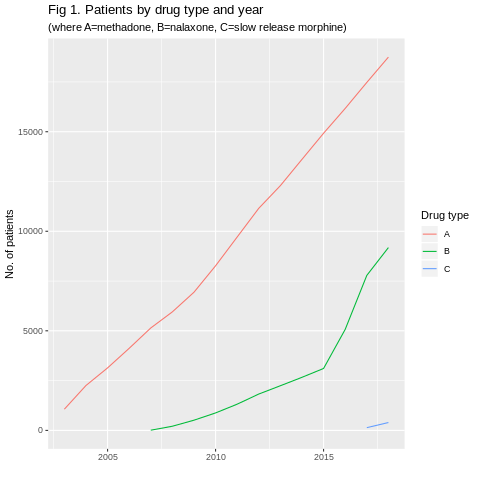

In [44]:
%%R
ggplot()+geom_line(aes(y=grp$'n', x=grp$'year', color=grp$'drug'),size=.5, data=grp)+
  labs(title = "Fig 1. Patients by drug type and year ",
       subtitle ="(where A=methadone, B=nalaxone, C=slow release morphine)", y = "No. of patients", x = "")+
     labs(color='Drug type')

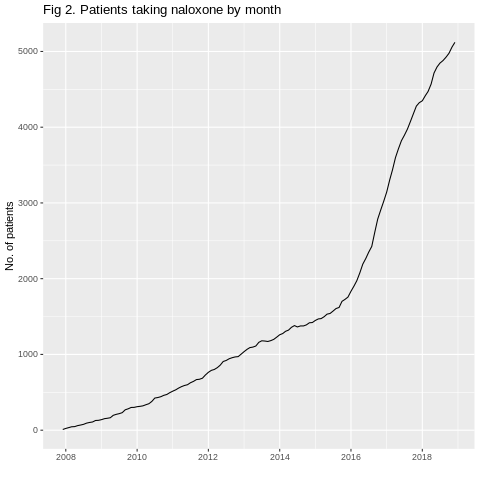

In [106]:
%%R
#visual inspection for drug B
grp2<- subset(df, drug=='B') 
grp2<-grp2%>% select(-drug) %>% group_by(mnth) %>% 
  summarise(n = n_distinct(id))
ggplot()+geom_line(aes(y=grp2$'n', x=grp2$'mnth'),size=.5, data=grp2)+ 
  labs(title = "Fig 2. Patients taking naloxone by month ", y = "No. of patients", x = "")

In [99]:
%%R
#difference = y-y(lag)
grp4 <-grp3[c('mnth','n')]
grp4$lag <- sapply(1:nrow(grp4), function(x) grp4$n[x-1])
grp4$lag <- c(NA, grp4$n[seq_along(grp4$n) -1])
grp4$d<-(grp4$n-grp4$lag) 
grp4a<-grp4[c('mnth', 'd')] 
glimpse(grp4a)


Observations: 133
Variables: 2
$ mnth <dttm> 2007-12-01, 2008-01-01, 2008-02-01, 2008-03-01, 2008-04-01, 200…
$ d    <int> NA, 14, 11, 11, 2, 13, 8, 9, 16, 9, 6, 20, 2, 9, 13, 5, 7, 32, 1…


In [104]:
%%R
#t-test
grp5<-subset(grp4a, mnth <'2015-10-01')  %>% remove_rownames %>% column_to_rownames(var="mnth")
grp6<-subset(grp4a,mnth >='2015-10-01' & mnth< '2016-07-01')%>% remove_rownames %>% column_to_rownames(var="mnth")
grp7<-subset(grp4a, mnth >'2016-07-01')%>% remove_rownames %>% column_to_rownames(var="mnth")
glimpse(grp6)
t.test(grp5,grp6)  

Observations: 9
Variables: 1
$ d <int> 81, 26, 30, 77, 69, 71, 104, 114, 75

	Welch Two Sample t-test

data:  grp5 and grp6
t = -5.5707, df = 8.2738, p-value = 0.0004687
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -77.02485 -32.10777
sample estimates:
mean of x mean of y 
 17.32258  71.88889 



In [105]:
%%R
t.test(grp6,grp7)


	Welch Two Sample t-test

data:  grp6 and grp7
t = -1.8715, df = 20.104, p-value = 0.0759
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -49.955362   2.698657
sample estimates:
mean of x mean of y 
 71.88889  95.51724 



In [67]:
%%R
t.test(grp6,grp7)


	Welch Two Sample t-test

data:  grp6 and grp7
t = -1.8715, df = 20.104, p-value = 0.0759
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -49.955362   2.698657
sample estimates:
mean of x mean of y 
 71.88889  95.51724 



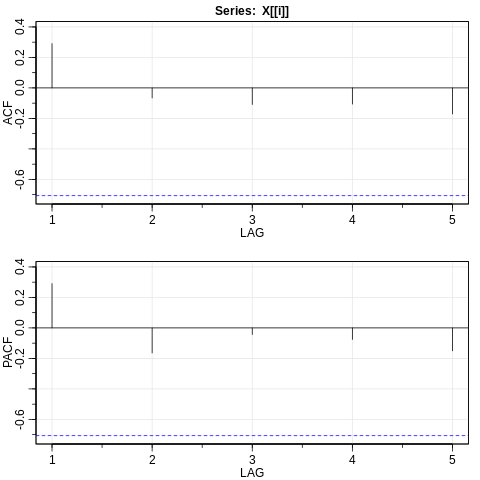

In [0]:
%%R
acf_df <- lapply(X = s, FUN = acf2)

$pred
Time Series:
Start = 9 
End = 11 
Frequency = 1 
[1] 0.1908214 0.1920561 0.1930720

$se
Time Series:
Start = 9 
End = 11 
Frequency = 1 
[1] 0.0003052216 0.0008252109 0.0013434930



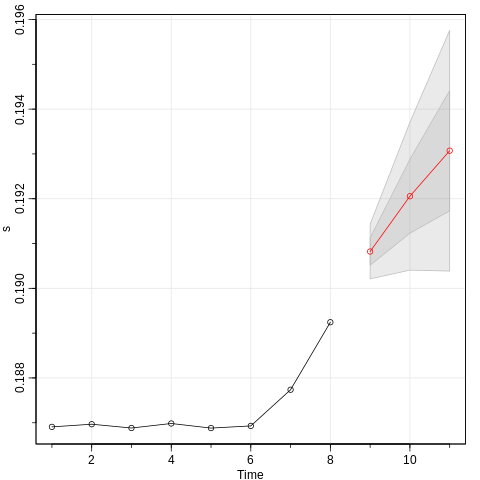

In [0]:
%%R
sarima.for(s, n.ahead = 3, 1, 1, 1) 